## Import Libraries and Load Dataset

In [2]:
# NBA Player Performance Prediction Notebook

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

In [5]:
# Load Dataset
# Dataset csv file is in same directory as the code file.
data = pd.read_csv('all_seasons.csv')

## Basic Dataset Information 

In [6]:
# Display basic information about the dataset
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12844 entries, 0 to 12843
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_id          12844 non-null  int64  
 1   player_name        12844 non-null  object 
 2   team_abbreviation  12844 non-null  object 
 3   age                12844 non-null  int64  
 4   player_height      12844 non-null  float64
 5   player_weight      12844 non-null  float64
 6   college            12844 non-null  object 
 7   country            12844 non-null  object 
 8   draft_year         12844 non-null  object 
 9   draft_round        12844 non-null  object 
 10  draft_number       12844 non-null  object 
 11  gp                 12844 non-null  int64  
 12  pts                12844 non-null  float64
 13  reb                12844 non-null  float64
 14  ast                12844 non-null  float64
 15  net_rating         12844 non-null  float64
 16  oreb_pct           128

## Exploratory Data Analysis (EDA)

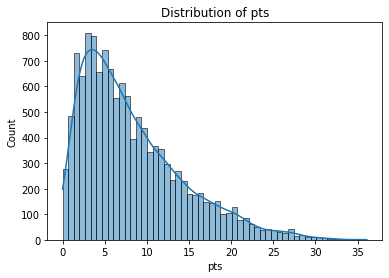

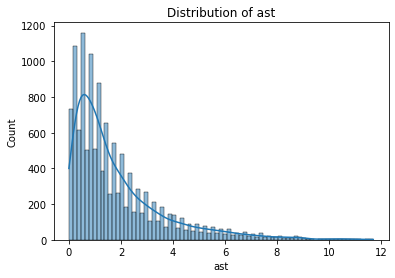

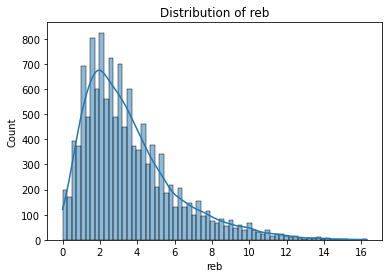

In [4]:
# Exploratory Data Analysis (EDA)
# Distribution of key statistics
key_stats = ['pts', 'ast', 'reb']
for stat in key_stats:
    sns.histplot(data[stat], kde=True)
    plt.title(f"Distribution of {stat}")
    plt.show()

## Correlation Analysis

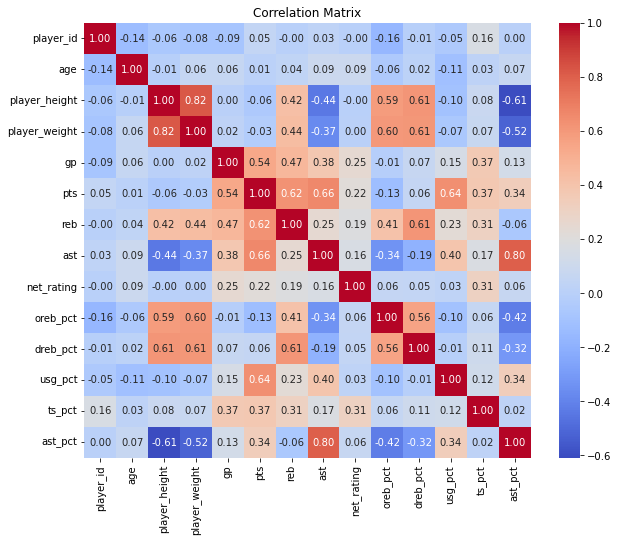

In [9]:
# Correlation analysis
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

## Feature Engineering

In [14]:
# Feature Engineering
# Adding moving averages for performance trends
data['points_avg_last_5'] = data.groupby('player_id')['pts'].rolling(window=5).mean().reset_index(0, drop=True)
data['assists_avg_last_5'] = data.groupby('player_id')['ast'].rolling(window=5).mean().reset_index(0, drop=True)
data['rebounds_avg_last_5'] = data.groupby('player_id')['reb'].rolling(window=5).mean().reset_index(0, drop=True)

# Fill any NaN values generated during rolling mean
data.fillna(0, inplace=True)


## Feature Selection

In [21]:
# Feature Selection
# Target variable
target = 'pts'  
features = data.drop(columns=['player_id', 'pts', 'season'])  
target_data = data[target]

# Ensure all features are numeric
features = features.select_dtypes(include=['number'])

# Remove constant or near-constant features
features = features.loc[:, features.std() > 0]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Handle any NaN or infinite values in features_scaled
features_scaled = np.nan_to_num(features_scaled)

# Correlation-based feature selection
selector = SelectKBest(score_func=f_regression, k=10)
features_selected = selector.fit_transform(features_scaled, target_data)

# Get selected feature names
selected_feature_names = features.columns[selector.get_support()]
print("Selected Features:")
print(selected_feature_names)


Selected Features:
Index(['player_height', 'gp', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct'],
      dtype='object')


## Model Training and Evaluation 

In [24]:
# Prepare data for modeling
X = features_selected
y = target_data

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Evaluation metrics
print("Linear Regression:")
print(f"R-squared: {r2_score(y_test, y_pred_lr):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_lr):.4f}")

print("\nRidge Regression:")
print(f"R-squared: {r2_score(y_test, y_pred_ridge):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_ridge):.4f}")

Linear Regression:
R-squared: 0.8890
Mean Absolute Error: 1.3632

Ridge Regression:
R-squared: 0.8890
Mean Absolute Error: 1.3633


## Evaluation Metrics

In [26]:
def evaluate_model(model_name, y_test, y_pred):
    print(f"{model_name} Evaluation:")
    print(f"R-squared: {r2_score(y_test, y_pred):.2f}")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.2f}\n")

evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Ridge Regression", y_test, y_pred_ridge)

Linear Regression Evaluation:
R-squared: 0.89
Mean Absolute Error (MAE): 1.36

Ridge Regression Evaluation:
R-squared: 0.89
Mean Absolute Error (MAE): 1.36



## Feature Analysis 

Feature Importance (Linear Regression):
         Feature  Coefficient
2            reb     3.012799
3            ast     2.907359
7        usg_pct     2.317279
8         ts_pct     0.531954
1             gp     0.397657
4     net_rating     0.149435
0  player_height     0.058170
5       oreb_pct    -0.951099
6       dreb_pct    -1.021932
9        ast_pct    -1.666800


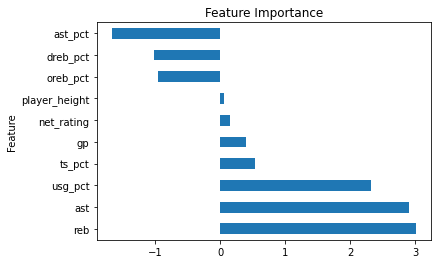

In [32]:
# Analyzing feature coefficients for linear regression
coefficients = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)

print("Feature Importance (Linear Regression):")
print(coefficients)

# Plot feature importance
coefficients.plot(x='Feature', y='Coefficient', kind='barh', title='Feature Importance', legend=False)
plt.show()